In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *
import os
from numpy.lib.recfunctions import append_fields
import scipy.stats

import matplotlib.pyplot as plt
import numpy as np
from run_systematics import sys_iteration, weightmultiply, fitting_allSP, calling_sysMap

#debugging:
#import ipdb
#ipdb.set_trace()

# calling map 
path = '/fs/scratch/PCON0008/warner785/bwarner/'
LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits') #BAO is different measurement, may be different from this analysis
# 'Y1LSSmask_v2_redlimcut_il22_seeil4.0_4096ring.fits'
#GoldMask = callingEliGoldMask()
LSSMask = LSSGoldmask
GoldMask = LSSGoldmask

pixra, pixdec = hp.pix2ang(nside=4096,ipix=GoldMask['PIXEL'],nest=True,lonlat=True)

LSSMask = LSSMask[pixdec >-3.0 ]
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ pixdec > -3.0 ]
GoldMask_spt = GoldMask[ pixdec < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

def calling_lens_catalog(catname=None):

    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
    os.system('mkdir '+catdir)
    dmass = esutil.io.read(catname)
    w_dmass = dmass['CMASS_PROB']
    print ('Calculating DMASS systematic weights...')
    dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
#   dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]   # for low probability galaxies
    esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')
    
    randoms = esutil.io.read('/fs/scratch/PCON0008/warner785/bwarner/random_dmass_y1_public_v1.fits')
#    randoms = esutil.io.read('/users/PCON0003/warner785/DMASSY3/output/test/train_cat/y3/dmass_st82_DET200_randoms.fits')
    
#    catdir = ''.join([ c+'/' for c in catname.split('/')[:-1]])
#    os.system('mkdir '+catdir)
#    dmass = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_sys_v3.fits')
    #w_dmass = dmass['CMASS_PROB'] *dmass['WEIGHT0_fwhm_r']*dmass['WEIGHT1_airmass_z']
    #print ('Calculatig DMASS systematic weights...')
    #dmass = appendColumn(dmass, name='WEIGHT', value= w_dmass )
    #dmass = dmass[ dmass['CMASS_PROB'] > 0.01 ]
    #esutil.io.write(catname, dmass)
    #randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

#    randoms = esutil.io.read('/n/des/lee.5922/data/dmass_cat/random_x50_dmass_spt_masked.fits')

    print ('Resulting catalog size')
    print ('DMASS=', np.sum(dmass['WEIGHT']) )
    print ('randoms=', randoms.size)
    return dmass, randoms

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des
    
def ra_dec_to_xyz(ra, dec):
    """Convert ra & dec to Euclidean points
    Parameters
    ----------
    ra, dec : ndarrays
    Returns
    x, y, z : ndarrays
    """
    sin_ra = np.sin(ra * np.pi / 180.)
    cos_ra = np.cos(ra * np.pi / 180.)

    sin_dec = np.sin(np.pi / 2 - dec * np.pi / 180.)
    cos_dec = np.cos(np.pi / 2 - dec * np.pi / 180.)

    return (cos_ra * sin_dec,
            sin_ra * sin_dec,
            cos_dec)

def uniform_sphere(RAlim, DEClim, size=1):
    """Draw a uniform sample on a sphere
    Parameters
    ----------
    RAlim : tuple
        select Right Ascension between RAlim[0] and RAlim[1]
        units are degrees
    DEClim : tuple
        select Declination between DEClim[0] and DEClim[1]
    size : int (optional)
        the size of the random arrays to return (default = 1)
    Returns
    -------
    RA, DEC : ndarray
        the random sample on the sphere within the given limits.
        arrays have shape equal to size.
    """
    zlim = np.sin(np.pi * np.asarray(DEClim) / 180.)

    z = zlim[0] + (zlim[1] - zlim[0]) * np.random.random(size)
    DEC = (180. / np.pi) * np.arcsin(z)
    RA = RAlim[0] + (RAlim[1] - RAlim[0]) * np.random.random(size)
    
    return RA, DEC

def uniform_random_on_sphere(data, size = None ):
    ra = data['RA']
    dec = data['DEC']
    
    n_features = ra.size
    #size = 100 * data.size
    
    # draw a random sample with N points
    ra_R, dec_R = uniform_sphere((min(ra), max(ra)),
                                 (min(dec), max(dec)),
                                 size)
    #data = np.asarray(ra_dec_to_xyz(ra, dec), order='F').T
    #data_R = np.asarray(ra_dec_to_xyz(ra_R, dec_R), order='F').T
    
    #random redshift distribution
    
    data_R = np.zeros((ra_R.size,), dtype=[('RA', 'float'), ('DEC', 'float')])
    data_R['RA'] = ra_R
    data_R['DEC'] = dec_R
                              
    return data_R

## ---------------------------------------------
# 2nd option: set seed -- get same randoms

# import DMASS in validation region
#lens, randoms = calling_lens_catalog('/fs/scratch/PCON0003/warner785/bwarner/dmass_y1_public_v1.fits')
dmass_val, randoms = calling_lens_catalog('../output/test/train_cat/y3/dmass_st82_DET200_VAL.fits')
# ('../output/test/train_cat/y3/dmass_st82_DET200_final.fits')

random_val = uniform_random_on_sphere(dmass_val, size = 10*int(np.sum(dmass_val['WEIGHT']))) #larger size of randoms
# applying LSS mask 
random_val = keepGoodRegion(random_val)

plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

random_val = appendColumn(random_val, value=np.ones(random_val.size), name='WEIGHT')

path = '/fs/scratch/PCON0008/warner785/bwarner/'
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')

phi = random_val['RA'] * np.pi / 180.0
theta = ( 90.0 - random_val['DEC'] ) * np.pi/180.0
random_pix = hp.ang2pix(4096, theta, phi)
print(random_pix.size)

frac = np.zeros(hp.nside2npix(4096))
fracDet["PIXEL"] = hp.nest2ring(4096, fracDet['PIXEL'])
#sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
frac[fracDet['PIXEL']] = fracDet['SIGNAL']

frac_obj = frac[random_pix]

u = np.random.rand(len(random_pix))
#select random points with the condition u < frac_obj
random_val_fracselected = random_val[u < frac_obj]

def cutPCA(sysMap):
    RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)
    sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
    sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)
    #print(sysMap.dtype.names)

    sysMap = keepGoodRegion(sysMap)
    
# for validation region
    mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
    mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
    sysMap = sysMap[mask4]
    
 # for training region
    #mask = (sysMap['RA']>310) & (sysMap['RA']<360)|(sysMap['RA']<7)
    #mask = mask & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
    #sysMap = sysMap[mask]
    
    return sysMap


def cut_and_downgradePCA(sysMap):
    #print(sysMap.dtype.names)

    RA, DEC = hp.pix2ang(4096, sysMap['PIXEL'], lonlat=True)
    sysMap = append_fields(sysMap, 'RA', RA, usemask=False)
    sysMap = append_fields(sysMap, 'DEC', DEC, usemask=False)
    #print(sysMap.dtype.names)

    sysMap = keepGoodRegion(sysMap)

    mask4 =(sysMap['RA']>18)&(sysMap['RA']<43)
    mask4 = mask4 & (sysMap['DEC']>-10) & (sysMap['DEC']<10)
    sysMap = sysMap[mask4]
    
    sysHp = np.full(hp.nside2npix(4096), hp.UNSEEN)
    #sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
    sysHp[sysMap['PIXEL']] = sysMap['SIGNAL']
    #print(sysHp.size)
    #print(sysHp[35369:35469])

    #print(sysMap['PIXEL'][dim_mask][0])

    nside_in = hp.pixelfunc.get_nside(sysHp)
    #print(nside_in)
    downgrade = hp.pixelfunc.ud_grade(sysHp, 512, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
    #downgrade128 = hp.pixelfunc.ud_grade(sysHp, 128, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
    #downgrade256 = hp.pixelfunc.ud_grade(sysHp, 256, pess=False, order_in='RING', order_out=None, power=None, dtype=None)

    #default order_out = ring, change to nest? -- check
    nside_out = hp.pixelfunc.get_nside(downgrade)
    #print(nside_out)

    n_good_pixels_at_512 = hp.nside2npix(nside_out)
    #np.zeros(n_good_pixels_at_512, dtype=[('PIXEL','int'), ('SIGNAL','float')] )
    pixels = np.zeros(n_good_pixels_at_512)
    #print(pixels.size)

    #print(hp.visufunc.mollview(sysHp))
    

    #print(sysMap.size)
    
    for x in range(pixels.size):
        if x>0:
            pixels[x]=pixels[x-1]+1
    #print(pixels)

    sysMap = np.zeros( len(pixels), dtype=[('HPIX_512','int'), ('SIGNAL','float'),('RA','float'),('DEC','float')])
    sysMap['HPIX_512'] = pixels
    sysMap['SIGNAL'] = downgrade

    #print(sysMap.size)
    #sysMap = keepGoodRegion(sysMap)
    #print(sysMap.size)

    #restrict to validation region area:
    RA, DEC = hp.pix2ang(512, sysMap['HPIX_512'], lonlat=True)
    #theta, phi = hp.pix2ang(512, sysMap['PIXEL'])
    ##sys_area = np.zeros( len(phi), dtype=[('RA','float'), ('DEC','float')] )

    # Convert silly ra/dec to silly HP angular coordinates.
    ##phi = des['RA'] * np.pi / 180.0
    #RA = phi*(180.0/np.pi)
    #DEC = -(180.0/np.pi)*theta+90.0
    ##theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    sysMap['RA']= RA
    sysMap['DEC'] = DEC
    
    return sysMap

def downgrade_fracDet(fracDet):
    frac = np.zeros(hp.nside2npix(4096))
    fracDet["PIXEL"] = hp.nest2ring(4096, fracDet['PIXEL'])
    #sysHp[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
    frac[fracDet['PIXEL']] = fracDet['SIGNAL']
    downgrade_frac = hp.pixelfunc.ud_grade(frac, 512, pess=False, order_in='RING', order_out=None, power=None, dtype=None)
    
    n_good_pixels_at_512 = hp.nside2npix(512)
    #np.zeros(n_good_pixels_at_512, dtype=[('PIXEL','int'), ('SIGNAL','float')] 
 
    pixels = np.arange( n_good_pixels_at_512)


    fracDet_512 = np.zeros( len(pixels), dtype=[('HPIX_512','int'), ('SIGNAL','float')])
    fracDet_512['HPIX_512'] = pixels
    fracDet_512['SIGNAL'] = downgrade_frac    
    
    return fracDet_512


def downgrade_dmass(dmass_val):
    index_mask = np.argsort(dmass_val['HPIX_4096'])
    dmass_chron = dmass_val[index_mask] # ordered by hpix values
    theta, phi = hp.pix2ang(4096, dmass_chron['HPIX_4096'], nest = True)
    HPIX_512 = hp.ang2pix(512, theta, phi)

    dmass_chron = append_fields(dmass_chron, 'HPIX_512', HPIX_512, usemask=False)
    
    return dmass_chron

def number_gal(sysMap, dmass_chron, sys_weights = False): # apply systematic weights here
    
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
    #maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    #maximum = np.max(sysMap['SIGNAL'][dim_mask])
    #print("min: ", minimum)
    #print("max: ", maximum)

    #pbin = np.linspace(-.03, .04, 1000)
    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2

    #x = np.zeros(hp.nside2npix(512))
    x = np.full(hp.nside2npix(4096), hp.UNSEEN)
    #print(x, sum(x))
    #x[sysMap['PIXEL'][dim_mask]] = sysMap['SIGNAL'][dim_mask]
#    x[sysMap['HPIX_512']] = sysMap['SIGNAL']
    x[sysMap['PIXEL']] = sysMap['SIGNAL']

    #print(hp.visufunc.mollview(x)) # this is fine
    #print(hp.UNSEEN)

    #systematic value at galaxy location:

#    sysval_gal = x[dmass_chron['HPIX_512']].copy()
    sysval_gal = x[dmass_chron['HPIX_4096']].copy()

    #which healpixels have values in the sysMap signal

    #print(sum(sysval_gal[sysval_gal != hp.UNSEEN]))
    #print(hp.UNSEEN)

    #print(x.size, sysval_gal.size, dmass_chron.size)
    #print(maximum, minimum)
    #print((sysval_gal != 0.0).any())
    
    if sys_weights == True:
        h,pedge1 = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]*dmass_chron["SYS_WEIGHT"][sysval_gal != hp.UNSEEN])
    else:
        h,pedge1 = np.histogram(sysval_gal[sysval_gal != hp.UNSEEN], bins=pbin, weights = dmass_chron["WEIGHT"][sysval_gal != hp.UNSEEN]) # -- density of dmass sample, not gold sample
    #print(h)
    
    #print("pedge1: ", pedge1)
    #print("pbin: ", pbin)
    
    return h, sysval_gal, pedge1

def area_pixels(sysMap, fracDet):
    
    #minimum = np.percentile(sysMap['SIGNAL'][dim_mask], 1)
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
    #maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    #print(minimum)
    #print(maximum)

    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2
# number of galaxies in each pixel:

    sys_signal = sysMap['SIGNAL']

    #print(sys_signal[sys_signal != hp.UNSEEN])
    #print(sys_signal[sys_signal != hp.UNSEEN].size)

    n,_ = np.histogram(sys_signal[sys_signal != hp.UNSEEN] , bins=pbin )
#    print('area without weights:')
#    print(n)

    #corrected fracDet nside 512 //

    #matched_sys2 = sysMap[dim_mask]
    sys = sysMap
#    mask = np.full(hp.nside2npix(512), hp.UNSEEN)
    mask = np.full(hp.nside2npix(4096), hp.UNSEEN)

#    print(fracDet_512["HPIX_512"])
#    print(fracDet["PIXEL"])

    #Only look at pixels where fracDet has value
#    frac_mask = np.in1d(fracDet_512["HPIX_512"], sys["HPIX_512"], assume_unique=False, invert=False)
    frac_mask = np.in1d(fracDet["PIXEL"], sys["PIXEL"], assume_unique=False, invert=False)

    #make an array with signals corresponding to pixel values 
#    mask[sys["HPIX_512"]] = sys["SIGNAL"]
    mask[sys["PIXEL"]] = sys["SIGNAL"]

    #array only including fracDet/sys seen pixels sys signal values 
    #print(mask[mask != hp.UNSEEN])
#    frac_sys = mask[fracDet_512["HPIX_512"][frac_mask]]
    frac_sys = mask[fracDet["PIXEL"][frac_mask]]

    #print(frac_sys[frac_sys != hp.UNSEEN])
    #print(frac_sys[frac_sys != hp.UNSEEN].size)

    #print(frac_sys[frac_sys != hp.UNSEEN])


    #print("sum: ", sum(fracDet_512["SIGNAL"]))

    #weights of fracDet in the overlap applied for accurate areas
    area,_ = np.histogram(frac_sys[frac_sys != hp.UNSEEN] , bins=pbin , weights = fracDet["SIGNAL"][frac_mask][frac_sys != hp.UNSEEN])
#    print('area with weights:')
#    print(area)
    # area = units of healpixels

    return area

def random_pixel(random_val_fracselected):
    phi = random_val_fracselected['RA'] * np.pi / 180.0
    theta = ( 90.0 - random_val_fracselected['DEC'] ) * np.pi/180.0
    nside= 4096

    HPIX_4096 = hp.ang2pix(4096, theta, phi)

    random_val = append_fields(random_val_fracselected, 'HPIX_4096', HPIX_4096, usemask=False)
    #print(random_val.dtype.names)
    
    return random_val

def downgrade_ran(random_val_fracselected):
    # convert nside for randoms:
    phi = random_val_fracselected['RA'] * np.pi / 180.0
    theta = ( 90.0 - random_val_fracselected['DEC'] ) * np.pi/180.0
    nside= 4096

    HPIX_512 = hp.ang2pix(512, theta, phi)

    random_val = append_fields(random_val_fracselected, 'HPIX_512', HPIX_512, usemask=False)
    #print(random_val.dtype.names)

    index_ran_mask = np.argsort(random_val['HPIX_512'])
    random_chron = random_val[index_ran_mask] # ordered by hpix values
    
    return random_chron


def number_density(sysMap, h, area):
    
    minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
    #minimum = np.min(sysMap['SIGNAL'][dim_mask]) #FWHM signal (for g filter)
    #maximum = np.percentile(sysMap['SIGNAL'][dim_mask], 99)
    maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
    #print(minimum)
    #print(maximum)

    pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
    pcenter = pbin[:-1] + pstep/2
    # change to number density: divide by area

    #fig, ax = plt.subplots()
    #ax.errorbar( pcenter, h_ran)
    #ax.legend(chi2_reduced)
    #plt.title('number of random galaxies per bin')
    #fig.savefig('ran_gal_bin.pdf')

    #print(hp.visufunc.mollview(sysMap['SIGNAL'][dim_mask]))

    # h_ran = number of galaxies
    #print("number of random galaxies: ", h_ran)

    # number density in bins: h/area

    number_density = []
    for x in range(len(h)):
        den = h[x]/area[x]
        number_density.append(den)
    
    #print("randoms number density: ", number_density_ran)


    total_area = 0
    #Normalize based on total number density of used footprint:
    for x in range(len(area)):
        total_area += area[x]

    #print("total_area: ", total_area)

    # total galaxies:
    total_h = 0
    for x in range(len(h)):
        total_h += h[x]

    #print("total galaxies: ", total_h)

    #normalization: 
    total_num_density = total_h/total_area

    #print("total number density: ", total_num_density_ran)
    
    # apply normalization: 
    #print(number_density)
    norm_number_density = number_density/total_num_density
    #print(norm_number_density_ran)

    fracerr = np.sqrt(h) #1 / sqrt(number of randoms cmass galaxies in each bin)
    fracerr_norm = (fracerr/area)/total_num_density
    #print("normalized error: ", fracerr_ran_norm)
    
    return pcenter, norm_number_density, fracerr_norm


def chi2(norm_number_density, x2_value, fracerr_norm, n):
    #chi**2 values for qualitative analysis:
    # difference of (randoms-horizontal line)**2/err_ran**2
    x1 = norm_number_density
    x2 = x2_value
    err = fracerr_norm
    chi2 = (x1-x2)**2 / err **2 
    chi2_reduced = sum(chi2)/(chi2.size-n)  # n = 2 for linear fit, 3 for quad.
    #print("chi2: ",chi2_reduced)
    
    return chi2, chi2_reduced

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


Calculating DMASS systematic weights...
Resulting catalog size
DMASS= 28744.940885503802
randoms= 5864645


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


219403


In [2]:
chi2_randoms = []
chi2_dmassi = []
chi2_trend1 = []
chi2_trend2 = []
chi2_dmassf = []
trend = []

In [3]:
input_path = '/fs/scratch/PCON0008/warner785/bwarner/pca_maps_jointmask_no_stars1623/'
#y3/band_z/
input_keyword = 'pca1_'
sysMap = io.SearchAndCallFits(path = input_path, keyword = input_keyword)

path = '/fs/scratch/PCON0008/warner785/bwarner/'
    
sys_weights = False
    
linear = False
quadratic = False
    
#    sysMap = cut_and_downgradePCA(sysMap)
sysMap = cutPCA(sysMap)
fracDet = fitsio.read(path+'y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz')
fracDet['PIXEL'] = hp.nest2ring(4096, fracDet['PIXEL'])
index_mask = np.argsort(dmass_val)
dmass_chron = dmass_val[index_mask] # ordered by hpix values
dmass_chron['HPIX_4096'] = hp.nest2ring(4096, dmass_chron['HPIX_4096'])

#out = '../output/test/train_cat/y3/'
out = '/fs/scratch/PCON0008/warner785/bwarner/'
h_ran = fitsio.read(out+input_keyword+'h_ran_val_lin2.fits')
norm_number_density_ran = fitsio.read(out+input_keyword+'norm_ran_val_lin2.fits')
fracerr_ran_norm = fitsio.read(out+input_keyword+'fracerr_ran_val_lin2.fits')
        
h, sysval_gal, pedge1 = number_gal(sysMap, dmass_chron, sys_weights = False)
area = area_pixels(sysMap, fracDet)
pcenter, norm_number_density, fracerr_norm = number_density(sysMap, h, area)


Calling catalogs >>>
pca1_ALL_maps_4096_ring_jointmask.fits.gz
reading 1/1 /fs/scratch/PCON0008/warner785/bwarner/pca_maps_jointmask_no_stars1623/pca1_ALL_maps_4096_ring_jointmask.fits.gz


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


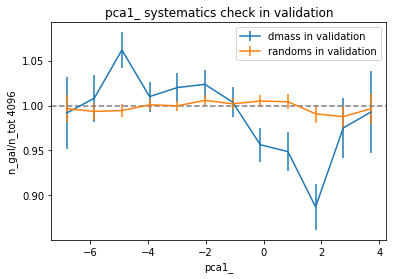

In [4]:
#plotting:

fig, ax = plt.subplots()
ax.errorbar( pcenter, norm_number_density, yerr=fracerr_norm, label = "dmass in validation")
ax.errorbar( pcenter, norm_number_density_ran, yerr=fracerr_ran_norm, label = "randoms in validation")
plt.legend()
xlabel = input_keyword
plt.xlabel(xlabel)
plt.ylabel("n_gal/n_tot 4096")
#plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
#    plt.title(xlabel+' systematic check')
if sys_weights == True:
    plt.title(xlabel+' sys weights applied in validation')
    fig.savefig(xlabel+'sys_applied_val.pdf')
else:
    plt.title(xlabel+' systematics check in validation')
    fig.savefig(xlabel+'sys_check_val.pdf')        

percentage in last bins:  4.911024449836826 %


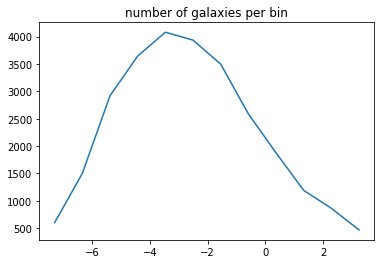

In [5]:
# truncating the data that goes against the trend-- if data is small enough to neglect
#print(h)
#print(pedge1)
fig, ax = plt.subplots()
#print(pedge1.size, h.size)

#mask1 = sysval_gal > pedge1[11]
#print(sysval_gal.size, dmass_chron.size)
ax.errorbar(pedge1[:-1], h)
#ax.hist(sysval_gal, bins=pedge1)
#h2, pedge2 = np.histogram(sysval_gal[mask1], bins=pedge1, weights = dmass_chron["WEIGHT"][mask1])
#ax.errorbar(pedge2[:-1], h2)

#print("dmass size: ", np.sum(dmass_chron["WEIGHT"][mask1]))
#print("sys:", np.sum(sysval_gal[mask1]))

sum_h = np.sum(h)
#print("sum_h", sum_h)
#sum_h2=h2[11] #+h2[11]
#print(sum_h2)

#ax.legend(chi2_reduced)
plt.title('number of galaxies per bin')

print("percentage in last bins: ", ((h[10]+h[11])/np.sum(h))*100, "%") #h[10]+

In [46]:
#??ax.hist

In [6]:
minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
print("min: ",minimum)
maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
print("max: ",maximum)
pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
print("pbin: ", pbin)
#print(pedge1)
print("pstep: ", pstep)
pcenter = pbin[:-1] + pstep/2
pedge = pbin[:-1] + pstep
#print(pedge1)

print("sum of bins", h[10]+h[11])
#cut_region = sysval_gal[sysval_gal >= pedge1[10]]
# pick edge of bin rather than center
#print(cut_region.size)

#want to compare the sum of dmass_chron[“WEIGHT”] in this region:
mask1 = sysval_gal > pedge1[10]
mask2 = sysval_gal != hp.UNSEEN
#print(np.sum(mask1),np.sum(mask2))
mask3 = sysval_gal < maximum
mask4 = sysval_gal > minimum
mask_tot = mask1&mask2&mask3&mask4
#print(np.sum(mask_tot))
cut_dmass = dmass_chron[mask_tot]
cut_sum = sum(cut_dmass['WEIGHT'])

print(cut_sum)

# systematic value at galaxy location---
#sysval_gal = x[dmass_chron['HPIX_4096']].copy()

# In the histogram, each bin is the sum of the weights
# sum the weights of objects with systematic above bin10: it will match

min:  -7.284759785638812
max:  4.188474168067781
pbin:  [-7.28475979 -6.32865696 -5.37255413 -4.4164513  -3.46034847 -2.50424564
 -1.54814281 -0.59203998  0.36406285  1.32016568  2.27626851  3.23237134
  4.18847417]
pstep:  0.9561028294755495
sum of bins 1334.2922028789617
1334.2922028789349


Text(0.5, 1.0, 'pca1_ systematics check')

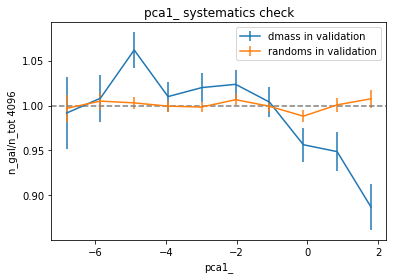

In [8]:
pcenter_new = pcenter[:-2]
norm_number_density_new = norm_number_density[:-2] # [:-1]
fracerr_norm_new = fracerr_norm[:-2]

norm_number_density_ran_new = norm_number_density_ran[:-2]
fracerr_ran_norm_new = fracerr_ran_norm[:-2]

fig, ax = plt.subplots()
ax.errorbar( pcenter_new, norm_number_density_new, yerr=fracerr_norm_new, label = "dmass in validation")
ax.errorbar( pcenter_new, norm_number_density_ran_new, yerr=fracerr_ran_norm_new, label = "randoms in validation")
plt.legend()
xlabel = input_keyword
plt.xlabel(xlabel)
plt.ylabel("n_gal/n_tot 4096")
#plt.ylim(top=1.2)  # adjust the top leaving bottom unchanged
#plt.ylim(bottom=0.85)
plt.axhline(y=1, color='grey', linestyle='--')
#    plt.title(xlabel+' systematic check')
plt.title(xlabel+' systematics check')

ran_chi2:  0.5323853364158809
checking chi2 before correction:  4.419962672647086
 
-0.01448 x + 0.9665
linear trend_chi2:  2.245703165627432
           2
-0.004003 x - 0.03239 x + 0.9659
quadratic trend_chi2:  0.9007201419214417
difference of chi2 between models:  11.660584331569364
Quadratic is better fit for  pca1_


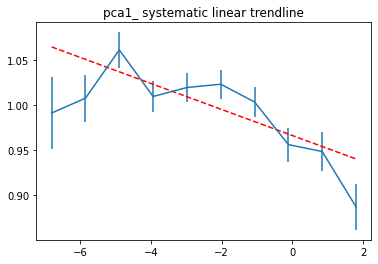

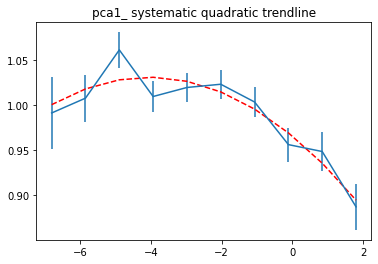

In [9]:
### errorbars taken into account with trends -- very important 
# weight option -- 1/err
# Over slack

ran_chi2, ran_chi2_reduced = chi2(norm_number_density_ran_new, 1, fracerr_ran_norm_new, 0)
print('ran_chi2: ', ran_chi2_reduced)
chi2_randoms.append(ran_chi2_reduced)
    
if sys_weights == True:
    trend_chi2, trend_chi2_reduced = chi2(norm_number_density_new, 1, fracerr_norm_new, 0)
    print('applied_sys_chi2: ', trend_chi2_reduced)
    chi2_dmassf.append(trend_chi2_reduced)
    
if sys_weights == False:    
    dmass_chi2, dmass_chi2_reduced = chi2(norm_number_density_new, 1, fracerr_norm_new, 0)
    print('checking chi2 before correction: ', dmass_chi2_reduced)
    chi2_dmassi.append(dmass_chi2_reduced)
        
    #trendline:
    # fit to trend:
    fig,ax = plt.subplots(1,1)
    #linear trends first -- chi2 for higher order study --- check for threshold value (afterward)
    z = np.polyfit(pcenter_new, norm_number_density_new, 1, w = 1/(fracerr_norm_new))
    p = np.poly1d(z)

    print(p)

    ax.plot(pcenter_new,p(pcenter_new),"r--")
    ax.errorbar( pcenter_new, norm_number_density_new, yerr=fracerr_norm_new, label = "dmass in validation")
    plt.title(xlabel+' systematic linear trendline')
    #fig.savefig(xlabel+'linear.pdf')

    trend_chi2, trend_chi2_reduced = chi2(norm_number_density_new, p(pcenter_new), fracerr_norm_new, 2)

    print('linear trend_chi2: ', trend_chi2_reduced)
    chi2_trend1.append(trend_chi2_reduced)
    
# difference between sum(chi2) between models (free parameters-- 1 new, want more than 1 better in sum(chi2))

    # second trendline:
    # fit to trend:
    fig,ax = plt.subplots(1,1)
    #linear trends first -- chi2 for higher order study --- check for threshold value (afterward)
    z2 = np.polyfit(pcenter_new, norm_number_density_new, 2, w = 1/fracerr_norm_new)
    p2 = np.poly1d(z2)

    print(p2)

    ax.plot(pcenter_new,p2(pcenter_new),"r--")
    ax.errorbar( pcenter_new, norm_number_density_new, yerr=fracerr_norm_new, label = "dmass in validation")
    plt.title(xlabel+' systematic quadratic trendline')
    #fig.savefig(xlabel+'quadratic.pdf')

    trend2_chi2, trend2_chi2_reduced = chi2(norm_number_density_new, p2(pcenter_new), fracerr_norm_new, 3)
    diff_chi2 = sum(trend_chi2)-sum(trend2_chi2)
    print('quadratic trend_chi2: ', trend2_chi2_reduced)
    chi2_trend2.append(trend2_chi2_reduced)

    print("difference of chi2 between models: ", diff_chi2)
    if diff_chi2 > 3:
        quadratic=True
        linear = False
        print("Quadratic is better fit for ", xlabel)
        trend.append(1)
    else:
        linear=True
        print("Linear fit is suitable for ", xlabel)
        trend.append(0)

In [87]:
# work on applying the weights to dmass:

#linear:
#weight_pixel = (1/p(sysMap["PIXEL"]))
minimum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 1)
maximum = np.percentile(sysMap['SIGNAL'][sysMap['SIGNAL']!=hp.UNSEEN], 99)
pbin, pstep = np.linspace( minimum, maximum, 13, retstep=True)
pcenter = pbin[:-1] + pstep/2
pedge = pbin[:-1] + pstep

if linear==True:
#check chi2 first
    chi2_ = np.linspace(0,30,100)
    #### CHANGE THIS LINE DEPENDING ON HOW MANY DATA POINTS ARE REMOVED:
    y = np.abs((100*(1.-scipy.stats.chi2(11).cdf(chi2_))-5.))  #for 5% p-value threshold
    index = np.where(y == y.min())[0][0]
    threshold = chi2_[index]
    if sum(trend_chi2)>threshold:
        print(xlabel, " NEEDS TO BE FLAGGED")
            
    #make sure object density stays the same
    #TAKE OUT PROBLEMATIC GALAXIES
    weight_object = (1/p(sysval_gal))
    weight_object[sysval_gal == hp.UNSEEN] = 0
    mask1 = sysval_gal > pedge1[9]
    mask2 = sysval_gal < maximum
    mask3 = sysval_gal > minimum
    mass_t = mask1&mask2&mask3
    weight_object[mass_t] = 0
    avg = np.average(weight_object[weight_object!=0])
#       print(avg)  # should be aprox. 1
        # normalize density
    weight_object = weight_object/avg
        
# quadratic:
#use weight_pixel for galaxies taken out
#weight_pixel = (1/p2(sysMap["PIXEL"]))
if quadratic==True:
    #check chi2 first
    chi2_ = np.linspace(0,30,100)
    #### CHANGE THIS LINE DEPENDING ON HOW MANY DATA POINTS ARE REMOVED:
    y = np.abs((100*(1.-scipy.stats.chi2(11).cdf(chi2_))-5.))  #for 5% p-value threshold****
    index = np.where(y == y.min())[0][0]
    threshold = chi2_[index]
    if sum(trend2_chi2)>threshold:
        print(xlabel, " NEEDS TO BE FLAGGED")
                    
    #make sure object density stays the same
    #TAKE OUT PROBLEMATIC GALAXIES
    weight_object = (1/p2(sysval_gal))
    weight_object[sysval_gal == hp.UNSEEN] = 0
    mask1 = sysval_gal > pedge1[9]
    mask2 = sysval_gal < maximum
    mask3 = sysval_gal > minimum
    mass_t = mask1&mask2&mask3
    weight_object[mass_t] = 0   
    avg = np.average(weight_object[weight_object!=0])
#          print(avg)  # should be aprox. 1
    #normalize density
    weight_object = weight_object/avg 

In [88]:
# modify GoldMask -- copy GoldMask into new -- sysMask with valid galaxies
#GoldMask = LSSGoldmask

# sysMap['PIXEL'], sysMap['SIGNAL']
mask1 = sysMap['SIGNAL'] < pedge1[1]
mask2 = sysMap['SIGNAL'] != hp.UNSEEN
mask3 = sysMap['SIGNAL'] < maximum
mask4 = sysMap['SIGNAL'] > minimum
mask_tot = mask1&mask2&mask3&mask4
tossed_hpix = sysMap[mask_tot]

New_GoldMask = LSSGoldmask.copy()
print(tossed_hpix['PIXEL'].size)

New_GoldMask = New_GoldMask[~np.in1d(New_GoldMask['PIXEL'],tossed_hpix['PIXEL'])]

outdir = '/fs/scratch/PCON0008/warner785/bwarner/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+xlabel+'New_GoldMask_val.fits', New_GoldMask, overwrite=True)  

7390


In [89]:
dmass_chron = append_fields(dmass_chron, 'SYS_WEIGHT', weight_object, usemask=False)
#        print(dmass_chron["SYS_WEIGHT"], dmass_chron["SYS_WEIGHT"].size)
    
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+xlabel+'dmass_sys_weight2_val.fits', dmass_chron, overwrite=True)    

In [5]:
# checking where to keep systematic weights:

file_path = '/users/PCON0003/warner785/DMASSY3/code_py3/'

with open(file_path + 'chi2_randoms_val_lin2.txt') as randoms:
#    w  = [float(x) for x in next(randoms).split()]
    chi2_randoms = [float(x) for x in randoms]
randoms.close()

with open(file_path + 'chi2_dmassi_val_lin2.txt') as dmass:
#    w  = [float(x) for x in next(dmass).split()]
    chi2_dmass = [float(x) for x in dmass]
dmass.close()
    
print(chi2_randoms)
print(chi2_dmass)

[1.1674693665830456, 0.41903463986954587, 1.2179354872093782, 0.630261232884847, 0.940313948389016, 1.273070203784683, 0.5450674269218398, 0.6877185484062833, 1.2232673467526458, 0.7488741601408536, 0.9789982333520696, 1.1560222861361238, 1.3435462651690167, 0.6285090358464998, 1.1114570706853995, 0.7799786021423123, 1.108584792604508, 0.9810838058043675, 0.6851205103245058, 1.3370652107670618, 0.6030294910890424, 0.770425532453332, 0.27334782569458665, 1.38016275923274, 1.7659851601766745, 0.2832332755510376, 0.9156686705156535, 1.1307368927402937, 1.2147650276200779, 1.3976660680940014, 1.4591188213885242, 1.6336304532292278, 1.8506892017178658, 0.832271690024249, 1.0662563645543568, 0.8025738677407689, 0.9876395731882771, 0.3301345539664848, 1.223405990844286, 1.536308476351003, 0.7507797575111308, 1.149359411656042, 0.8818556184554162, 0.42044246596389856, 0.5429134111041715, 1.0013737515234222, 1.6343018656154653, 1.2027709514218488, 0.9139018592951379, 0.8477743789291284]
[1.4565

In [6]:
print(np.max(chi2_randoms))
threshold = []
paper = []
for x in range(50):
    threshold.append(np.max(chi2_randoms))
    paper.append(2)
#print(threshold)

1.8506892017178658


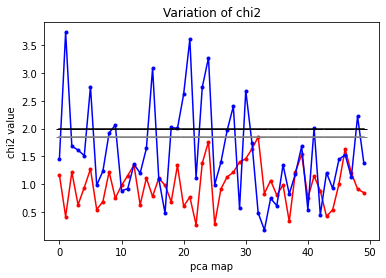

In [7]:
import matplotlib.pyplot as plt

plt.plot(chi2_randoms, color='red', marker='.')
plt.plot(chi2_dmass, color='blue', marker='.')
plt.plot(threshold, color='grey', marker='_')
plt.plot(paper, color='black', marker='_')
plt.ylabel('chi2 value') 
plt.xlabel('pca map')
plt.title("Variation of chi2") 
plt.show()

In [8]:
for x in range(len(chi2_dmass)-1):
    if chi2_dmass[x]>2:
        print(x, chi2_dmass[x])    

1 3.7324537304330487
5 2.75536443001017
9 2.0638858192923006
15 3.084687154166543
18 2.021882931719101
19 2.0020039117427753
20 2.6182165103759214
21 3.609332974089892
23 2.7444467944617625
24 3.273570677669966
28 2.4001152128016763
30 2.6836242137994843
41 2.0137364900499057
48 2.2191861253374907


In [6]:
# Apply Systematics into one weight

keyword_template = 'pca{0}_'
x = 1
dmass_chron = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/'+'pca0_'+'dmass_sys_weight_val_lin2.fits')
norm_weight1 = 1
#norm_weight1 = np.mean(dmass_chron['SYS_WEIGHT'][dmass_chron['SYS_WEIGHT']!=0])
dmass_chron_i = dmass_chron['SYS_WEIGHT']/norm_weight1
print(dmass_chron_i.size)
for i_pca in range(49): #50
    if chi2_dmass[x]>2:
#        if x!=1 and x!=21 and x!=48:
        input_keyword = keyword_template.format(i_pca)
        dmass_chron = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/'+input_keyword+'dmass_sys_weight_val_lin2.fits')
        norm_weight = 1
            #norm_weight = np.mean(dmass_chron['SYS_WEIGHT'][dmass_chron['SYS_WEIGHT']!=0])
        full_dmass_sysweights = (dmass_chron['SYS_WEIGHT']/norm_weight)*dmass_chron_i
        dmass_chron_i = full_dmass_sysweights
    x+=1

2740075


In [91]:
# reapplied weights:
i_pca = 19
for x in range(1):
#    if i_pca==1 or i_pca==21 or i_pca==48:
    if i_pca == 19
        input_keyword = keyword_template.format(i_pca)
        print(input_keyword)
        dmass_chron = fitsio.read('/fs/scratch/PCON0008/warner785/bwarner/'+input_keyword+'dmass_sys_weight_val_lin2.fits')
        norm_weight = 1
        #norm_weight = np.mean(dmass_chron['SYS_WEIGHT'][dmass_chron['SYS_WEIGHT']!=0])
        full_dmass_sysweights = (dmass_chron['SYS_WEIGHT']/norm_weight)*dmass_chron_i
        dmass_chron_i = full_dmass_sysweights
    i_pca+=1

pca1_
pca21_
pca48_


(array([1.000000e+01, 1.200000e+02, 1.590000e+02, 2.520000e+02,
        2.760000e+02, 5.320000e+02, 2.340000e+03, 8.073000e+03,
        6.674800e+04, 2.572337e+06]),
 array([0.29184702, 0.36408455, 0.43632209, 0.50855962, 0.58079715,
        0.65303469, 0.72527222, 0.79750975, 0.86974729, 0.94198482,
        1.01422235]),
 <a list of 10 Patch objects>)

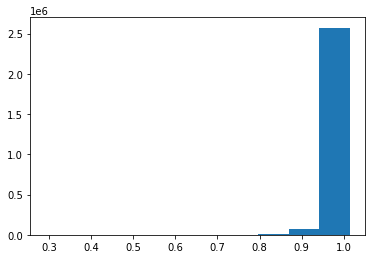

In [7]:
fig, ax = plt.subplots()
ax.hist(dmass_chron['SYS_WEIGHT'][dmass_chron['SYS_WEIGHT']!=0])

In [8]:
print(full_dmass_sysweights)

#fig, ax = plt.subplots()
#ax.hist(full_dmass_sysweights[full_dmass_sysweights!=0])

dmass_chron['SYS_WEIGHT'] = full_dmass_sysweights
outdir = '../output/test/train_cat/y3/'
os.makedirs(outdir, exist_ok=True)
esutil.io.write( outdir+'dmass_sys_weight_val_FULL_lin.fits', dmass_chron, overwrite=True)

[0.         0.         0.96192441 ... 1.1651084  1.07275613 1.0823058 ]


In [93]:
print(np.mean(full_dmass_sysweights))

0.8665206887269363


In [76]:
print(full_dmass_sysweights)

[0.         0.         1.01969432 ... 1.13715762 1.07799877 1.0740174 ]


(array([2.440676e+06, 6.802700e+04, 3.152000e+04, 1.963700e+04,
        1.390800e+04, 1.048100e+04, 8.649000e+03, 6.918000e+03,
        6.050000e+03, 5.171000e+03, 4.684000e+03, 4.106000e+03,
        3.741000e+03, 3.346000e+03, 3.018000e+03, 2.783000e+03,
        2.606000e+03, 2.397000e+03, 2.281000e+03, 2.088000e+03,
        1.970000e+03, 1.838000e+03, 1.760000e+03, 1.605000e+03,
        1.605000e+03, 1.481000e+03, 1.437000e+03, 1.287000e+03,
        1.264000e+03, 1.209000e+03]),
 array([0.        , 0.00166667, 0.00333333, 0.005     , 0.00666667,
        0.00833333, 0.01      , 0.01166667, 0.01333333, 0.015     ,
        0.01666667, 0.01833333, 0.02      , 0.02166667, 0.02333333,
        0.025     , 0.02666667, 0.02833333, 0.03      , 0.03166667,
        0.03333333, 0.035     , 0.03666667, 0.03833333, 0.04      ,
        0.04166667, 0.04333333, 0.045     , 0.04666667, 0.04833333,
        0.05      ]),
 <a list of 30 Patch objects>)

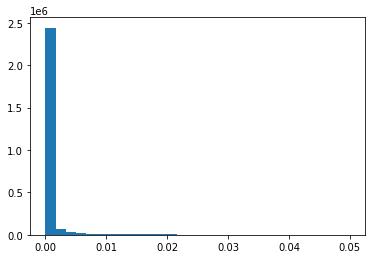

In [99]:
fig, ax = plt.subplots()
ax.hist(dmass_chron['WEIGHT'], range = (0,0.05), bins = 30)

# what fraction of objects in ~ 0.01 etc

In [ ]:
# weights
# total weighted number of DMASS (training) and CMASS in training
#dmass_chron["WEIGHT"]*dmass_chron["SYS_WEIGHT"]

In [ ]:
#loading in files (for CMASS)

In [102]:
import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [103]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
sys.path.append('../')
from xd import *
from run_DMASS import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())
from xdgmm import XDGMM as XDGMM_Holoien
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3
/users/PCON0003/warner785/DMASSY3/code_py3


In [104]:
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0008/warner785/bwarner/gold_full/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'gold_st82_final'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82_new = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82_new)
gold_st82_new = gold_st82_new[mask_magcut]
gold_st82_new = gold_st82_new[(gold_st82_new['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0008/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82_new.size)    
gold_st82_new = keepGoodRegion(gold_st82_new)
print(gold_st82_new.size)


Calling catalogs >>>
gold_st82_final_000056.fits
gold_st82_final_000003.fits
gold_st82_final_000026.fits
gold_st82_final_000121.fits
gold_st82_final_000094.fits
gold_st82_final_000040.fits
gold_st82_final_000010.fits
gold_st82_final_000082.fits
gold_st82_final_000068.fits
gold_st82_final_000075.fits
gold_st82_final_000103.fits
gold_st82_final_000112.fits
gold_st82_final_000043.fits
gold_st82_final_000125.fits
gold_st82_final_000083.fits
gold_st82_final_000101.fits
gold_st82_final_000016.fits
gold_st82_final_000031.fits
gold_st82_final_000041.fits
gold_st82_final_000052.fits
gold_st82_final_000092.fits
gold_st82_final_000027.fits
gold_st82_final_000127.fits
gold_st82_final_000095.fits
gold_st82_final_000114.fits
gold_st82_final_000079.fits
gold_st82_final_000045.fits
gold_st82_final_000086.fits
gold_st82_final_000007.fits
gold_st82_final_000029.fits
gold_st82_final_000055.fits
gold_st82_final_000076.fits
gold_st82_final_000069.fits
gold_st82_final_000105.fits
gold_st82_final_000100.fit

In [105]:
#training region check

mask = (gold_st82_new['RA']>310) & (gold_st82_new['RA']<360)|(gold_st82_new['RA']<7)
mask = mask & (gold_st82_new['DEC']>-10) & (gold_st82_new['DEC']<10)
gold_st82_train = gold_st82_new[mask]

mag = ['MAG_DETMODEL', 'MAG_DETMODEL']
err = ['MAGERR_DETMODEL', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

print(gold_st82_train.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

cmass_fraction_200 = clean_cmass_data_des_train.size *1./gold_st82_train.size
print(cmass_fraction_200)


1855129
0.011133457565484664


In [ ]:
# weights
# total weighted number of DMASS (training) and CMASS in training
dmass_weight = dmass_chron["WEIGHT"]*dmass_chron["SYS_WEIGHT"]
number = np.sum(dmass_weight)
# area -- using mask defined (fractional coverage)